# Figure 20

In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://128.196.236.68/2698/1 Dashboard: http://localhost:44006/status,Cluster Workers: 1 Cores: 8 Memory: 67.54 GB


In [2]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 133.683594 MB


# Variables

In [3]:
#### possible input info from external text file
# constant setting
tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['psl','uas','vas']
Area_name = ['areacello']

Model_name = ['JRAdo55']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'psl'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/input4MIPs/JRAdo55/'
modelfile = 'JRAdo55_psl.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/input4MIPs/JRAdo55/'
modelfile = [['JRAdo55_psl.zarr'],
             ['JRAdo55_uas.zarr'],
             ['JRAdo55_vas.zarr']]

path[model]=[modeldir,modelfile]

# model = Model_name[1]
# modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
# modelfile = [['CORE_zos.zarr']]
# path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [4]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
syear = 1993            
fyear = 2007

nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [5]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRAdo55 psl
read JRAdo55 uas
read JRAdo55 vas


In [6]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist[model][var].time.copy()
        year = ds_model_mlist[model][var]['time.year'].values
        month = ds_model_mlist[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist[model][var] = ds_model_mlist[model][var]-\
                                     (da_time*linear_mlist[model][var]['slope']+linear_mlist[model][var]['intercept'])

In [7]:
used_memory()

used 664.750000 MB


In [8]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
syear1 = 1958            
fyear1 = 2007

nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist1 = {}
mean_mlist1 = {}
season_mlist1 = {}
linear_mlist1 = {}

In [9]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear1)&\
                                 (ds_model['time.year'] <= fyear1)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist1[model] = linear_list
    mean_mlist1[model] = mean_list
    season_mlist1[model] = season_list
    ds_model_mlist1[model] = ds_model_list

read JRAdo55 psl
read JRAdo55 uas
read JRAdo55 vas


In [10]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist1[model][var].time.copy()
        year = ds_model_mlist1[model][var]['time.year'].values
        month = ds_model_mlist1[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist1[model][var] = ds_model_mlist1[model][var]-\
                                     (da_time*linear_mlist1[model][var]['slope']+linear_mlist1[model][var]['intercept'])

In [11]:
used_memory()

used 1979.687500 MB


# Regridding

In [12]:
#### models
da_model_standard = mean_mlist1['JRAdo55']['psl']

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [13]:
used_memory()

used 1979.695312 MB


In [14]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='lon',
                       lat_name='lat', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [15]:
import xesmf as xe

# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(mean_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRAdo55_psl2JRA_psl.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRAdo55_uas2JRA_psl.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRAdo55_vas2JRA_psl.nc 
 You can set reuse_weights=True to save computing time.


# El Nino

In [16]:
# noi
path = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/regional_avg/'
file = 'JRA_tos_oni_ts.nc'
ds_oni = xr.open_dataset(path+file)

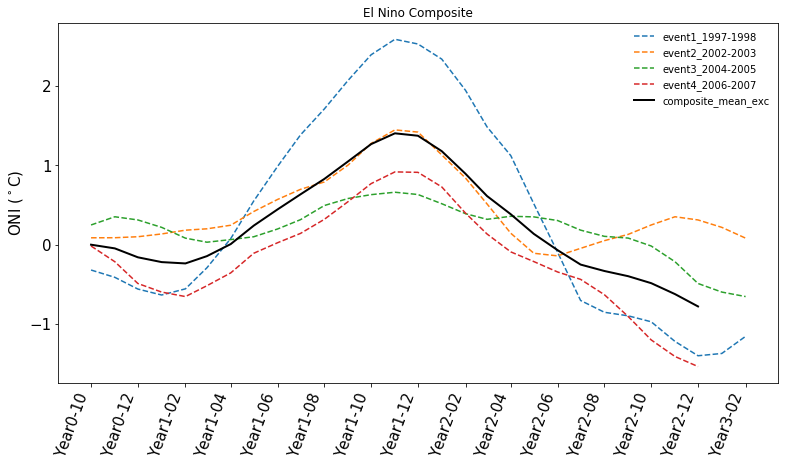

In [17]:
import importlib
import enso_composite
importlib.reload(enso_composite)

from enso_composite import elnino_composite

ds_oni_comp = elnino_composite(ds_oni.oni,syear,fyear,premon=13,postmon=15,period_type='maxval',exclude=[])

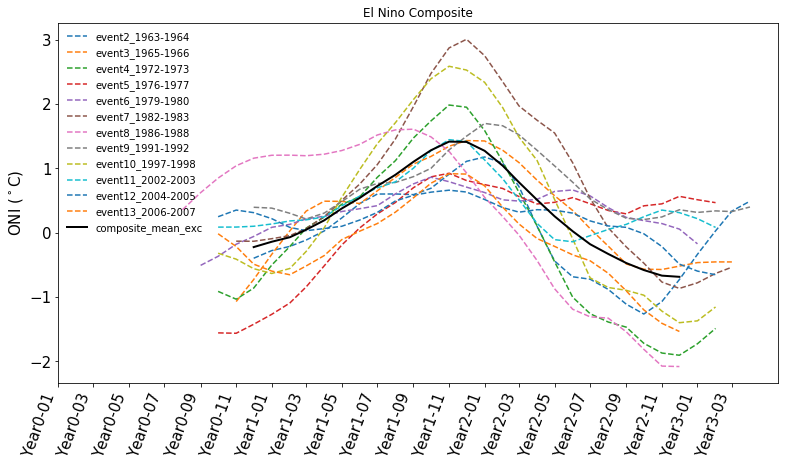

In [18]:
import importlib
import enso_composite
importlib.reload(enso_composite)

from enso_composite import elnino_composite

ds_oni_comp1 = elnino_composite(ds_oni.oni,syear1,fyear1,premon=13,postmon=15,period_type='maxval',exclude=[1])

In [19]:
import importlib
import enso_composite
importlib.reload(enso_composite)
from enso_composite import proc_elnino_composite_maps

elninocomp_mlist = {}
elninocomp_mlist1 = {}
for nmodel,model in enumerate(Model_name):
    elninocomp_list = {}
    elninocomp_list1 = {}
    for nvar,var in enumerate(Model_varname):
        elninocomp_list[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_model_mlist[model][var],
                                                        syear,
                                                        fyear,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[])
        elninocomp_list1[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_model_mlist1[model][var],
                                                        syear1,
                                                        fyear1,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[1])
    elninocomp_mlist[model] = elninocomp_list
    elninocomp_mlist1[model] = elninocomp_list1

# Apply regridder

In [20]:
#### regridding elnino composite field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            elninocomp_mlist[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](elninocomp_mlist[model][var])
            elninocomp_mlist[model][var]['lon'] = da_model_standard.lon.values
            elninocomp_mlist[model][var]['lat'] = da_model_standard.lat.values
            
            elninocomp_mlist1[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](elninocomp_mlist1[model][var])
            elninocomp_mlist1[model][var]['lon'] = da_model_standard.lon.values
            elninocomp_mlist1[model][var]['lat'] = da_model_standard.lat.values

# Plotting

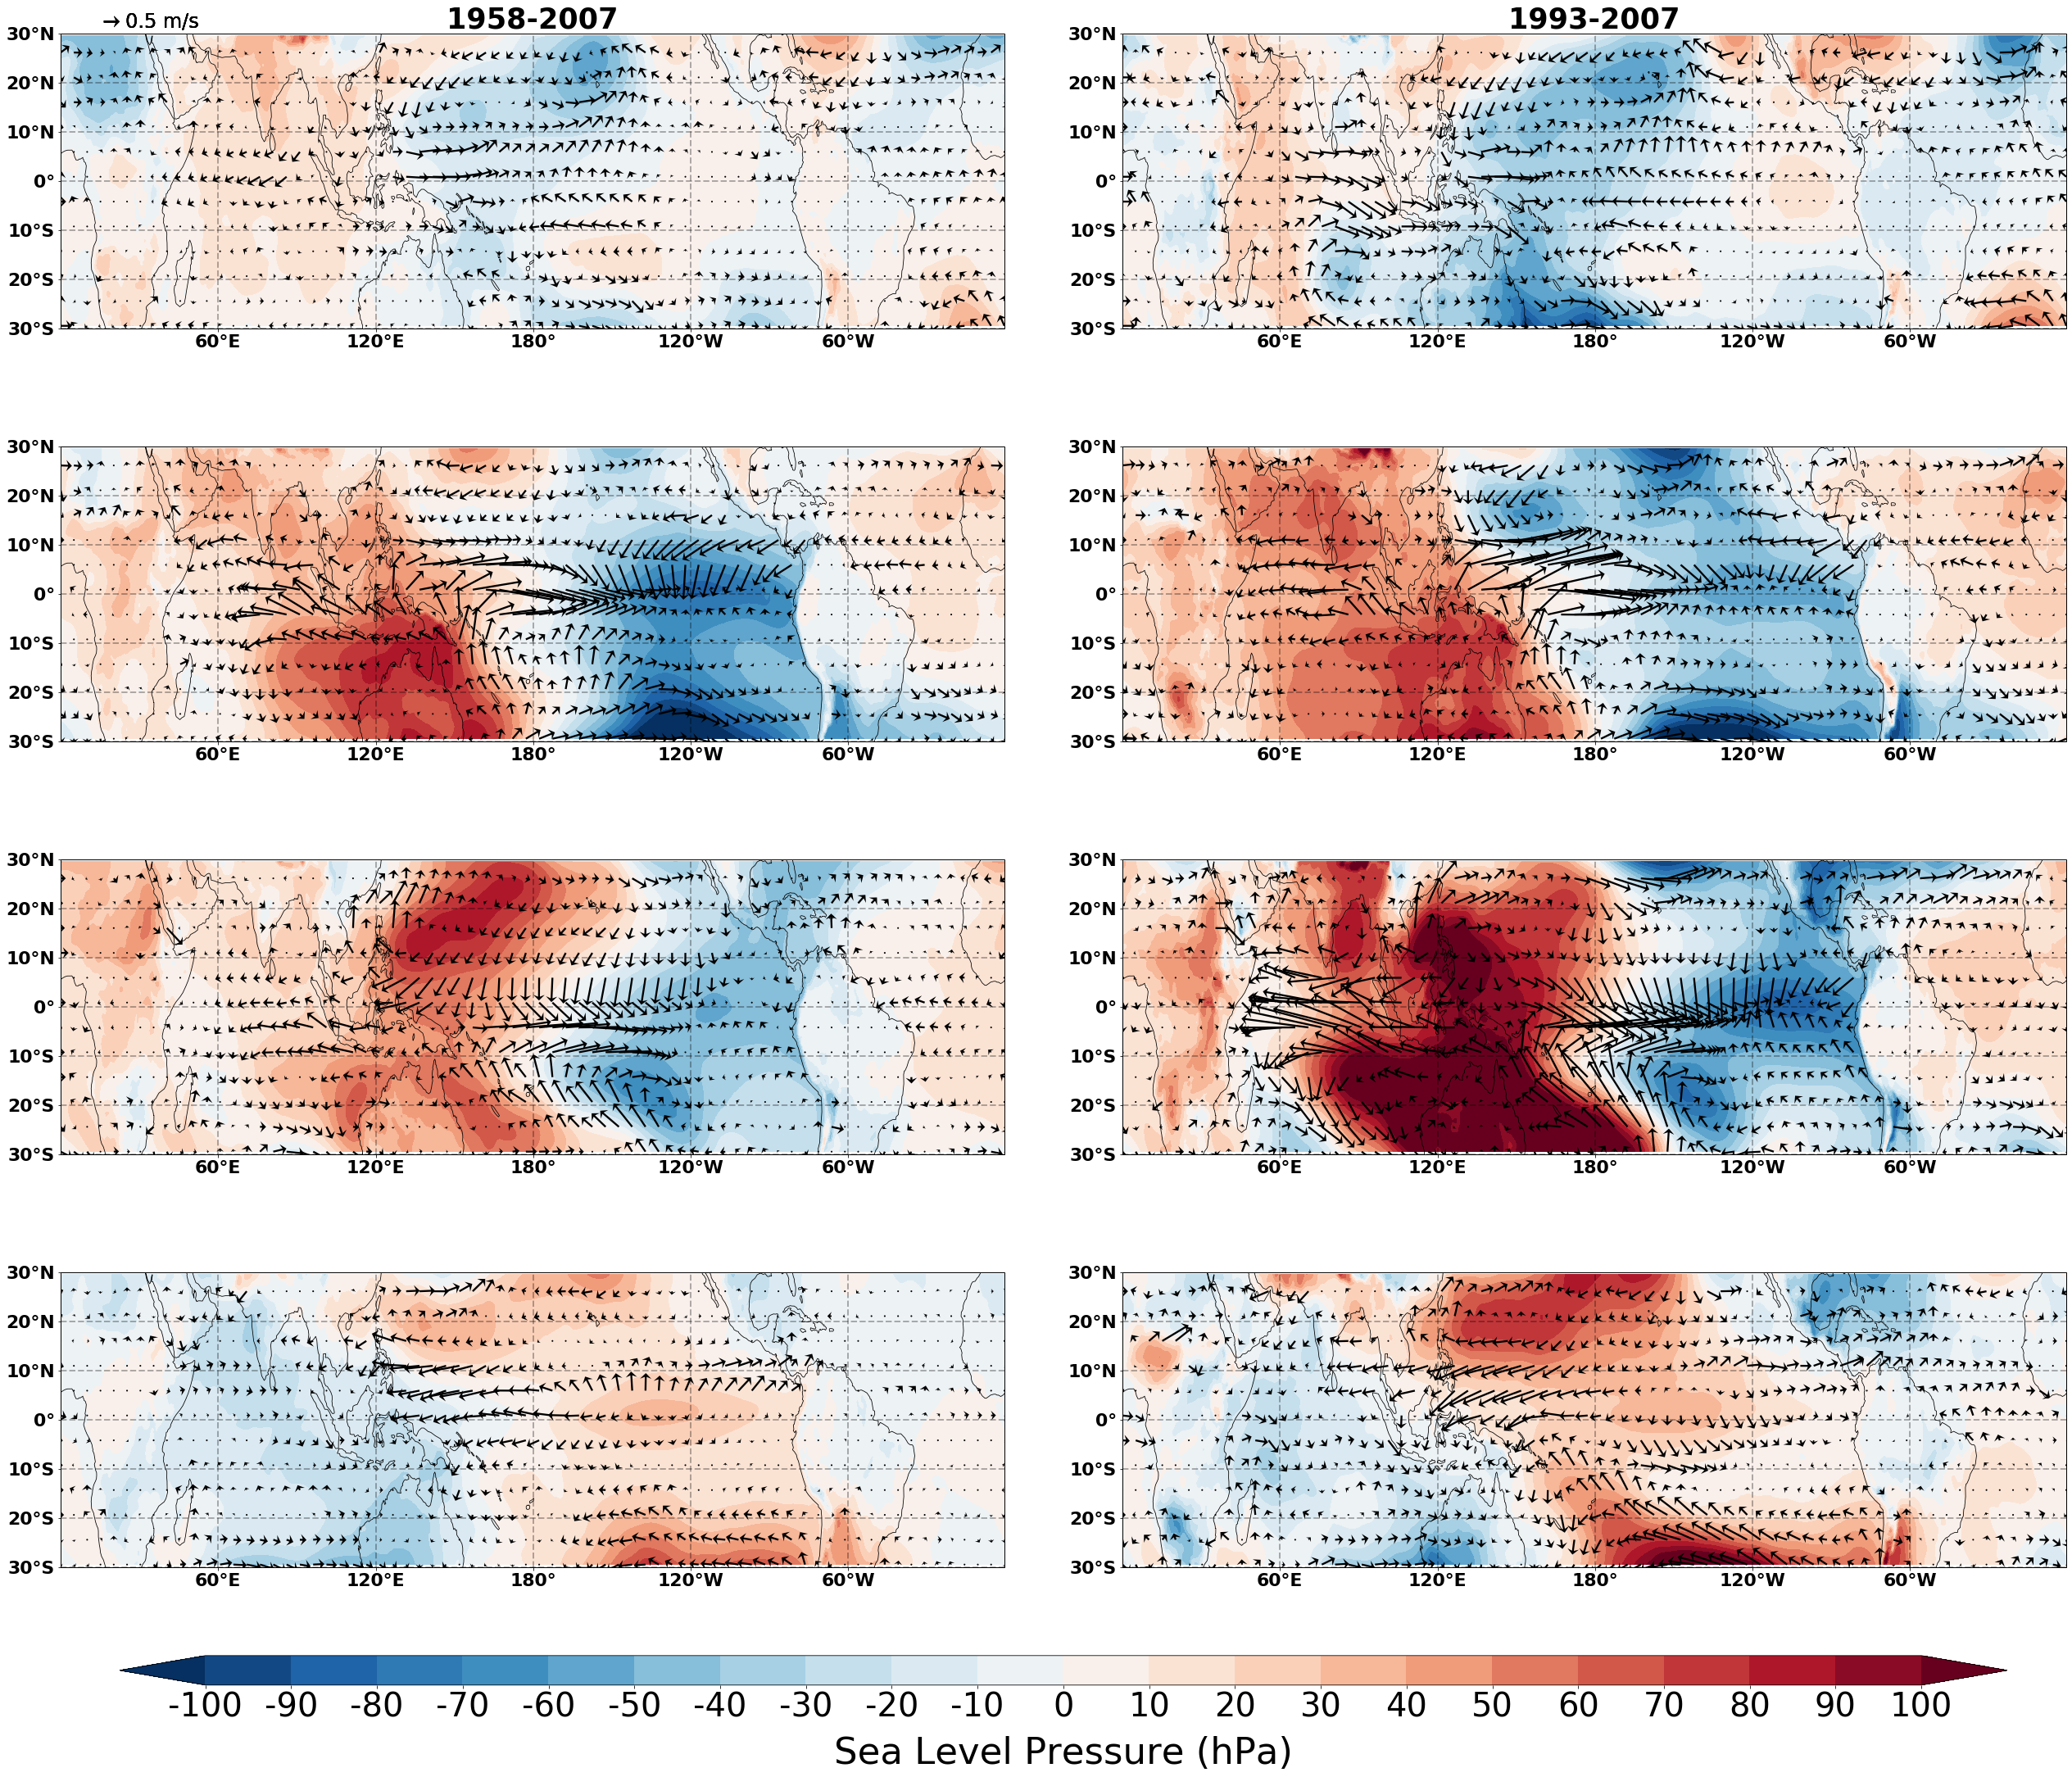

In [21]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
scale = 30  # wind field scale
gap = 9     # wind field gaps

time_range = [[ 0,1,2,3,4,5],
              [ 6,7,8,9,10,11,12],
              [12,13,14,15,16,17],
              [18,19,20,21,22,23]]

time_range_name = ["stage1","stage2","stage3","stage4"]

for ntrange,trange in enumerate(time_range) :

    #### plotting
    level=np.linspace(-100, 100, 21)

    ax2=fig.add_axes([0,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    im=(elninocomp_mlist1['JRAdo55']['psl'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',y='lat',
                                ax=ax2, levels=level, 
                                extend='both', cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0.))
    cb=im.colorbar
    cb.remove()
    
    var1 = 'uas'
    var2 = 'vas'
    # set gap in points to avoid graph too crowded
    
    q = ax2.quiver(elninocomp_mlist1[model][var1].isel(time=trange).mean('time').lon.values[::gap],
                   elninocomp_mlist1[model][var1].isel(time=trange).mean('time').lat.values[::gap],
                   elninocomp_mlist1[model][var1].isel(time=trange).mean('time').values[::gap, ::gap],
                   elninocomp_mlist1[model][var2].isel(time=trange).mean('time').values[::gap, ::gap],
                   scale=scale,units='width',headwidth=6,headaxislength=2,headlength=3,width=0.002,
                   transform=ccrs.PlateCarree(central_longitude=0))
    qk = ax2.quiverkey(q, 0.05, 0.52, 0.5, r'0.5 m/s', labelpos='E',
                   coordinates='figure',fontproperties={'size':24})

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.set_xticks([ 60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([ 60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if ntrange == 0 :
        ax2.set_title('1958-2007', color='black', weight='bold',size=35)
    ax2.set_aspect('auto')
    ax2=None


    #### plotting
    ax2=fig.add_axes([0+0.9,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))

    im=(elninocomp_mlist['JRAdo55']['psl'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
    var1 = 'uas'
    var2 = 'vas'
    # set gap in points to avoid graph too crowded
    
    q = ax2.quiver(elninocomp_mlist[model][var1].isel(time=trange).mean('time').lon.values[::gap],
                   elninocomp_mlist[model][var1].isel(time=trange).mean('time').lat.values[::gap],
                   elninocomp_mlist[model][var1].isel(time=trange).mean('time').values[::gap, ::gap],
                   elninocomp_mlist[model][var2].isel(time=trange).mean('time').values[::gap, ::gap],
                   scale=scale,units='width',headwidth=6,headaxislength=2,headlength=3,width=0.002,
                   transform=ccrs.PlateCarree(central_longitude=0))
    
    if ntrange == 0 :
        ax2.set_title('1993-2007', color='black', weight='bold',size=35)

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_aspect('auto')

    

cbaxes=fig.add_axes([0.05,0-ntrange*devy-0.2,1.6,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n) for n in level]) # 
cbar.ax.tick_params(labelsize=40,rotation=0) 
cbar.set_label(label='Sea Level Pressure (hPa)',size=45, labelpad=15)

fig.savefig('../figure/figure20.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)